In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import AgglomerativeClustering
from matplotlib import colors
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
%matplotlib inline

In [2]:
cmap = colors.ListedColormap(["#fde725", "#5ec962", "#21918c", "#3b528b", "#440154"])

In [3]:
data = pd.read_csv("marketing_campaign.csv", sep="\t")

In [4]:
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


## Data Cleaning

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

From the above output, we can conclude and note that:

There are missing values in income
Dt_Customer that indicates the date a customer joined the database is not parsed as DateTime
There are some categorical features in our data frame; as there are some features in dtype: object). So we will need to encode them into numeric forms later.ter.

In [6]:
data.isnull().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

Here we can notice that 24 entries of the column are null. So using dropna() to remove the null values

In [7]:
data = data.dropna()
print("The total number of data-points after removing the rows with missing values are:", len(data))

The total number of data-points after removing the rows with missing values are: 2216


In [8]:
print('Rows: {}'.format(data.shape[0]))
print('Columns: {}'.format(data.shape[1]))

Rows: 2216
Columns: 29


In [9]:
data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"], format="%d-%m-%Y")
dates = data["Dt_Customer"].dt.date
print("The newest customer's enrolment date in the records:", dates.max())
print("The oldest customer's enrolment date in the records:", dates.min())

The newest customer's enrolment date in the records: 2014-06-29
The oldest customer's enrolment date in the records: 2012-07-30


In [10]:
days = []
d1 = max(dates) #taking it to be the newest customer
for i in dates:
    delta = d1 - i
    days.append(delta)
data["Customer_For"] = days
data["Customer_For"] = pd.to_numeric(data["Customer_For"], errors="coerce")

In the next step, we're creating a new feature based on the "Dt_Customer" column. This feature will show the number of days a customer has been registered in the firm's database. However, to keep things simple, we'll calculate it relative to the most recent customer in the data, rather than the actual date.

In [11]:
data.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response',
       'Customer_For'],
      dtype='object')

In [12]:
print('Total categories in the feature Martial_Status:\n', data['Marital_Status'].value_counts(), '\n')
print('Total categories in the feature education:\n', data['Education'].value_counts())

Total categories in the feature Martial_Status:
 Marital_Status
Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64 

Total categories in the feature education:
 Education
Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: count, dtype: int64


In [13]:
data.describe()

,ID,Year_Birth,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,...,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Customer_For
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.0,2216.0,2216.000000,2.216000e+03
mean,5588.353339,1968.820397,52247.251354,0.441787,0.505415,2013-07-10 11:29:27.509025280,49.012635,305.091606,26.356047,166.995939,...,0.073556,0.074007,0.073105,0.064079,0.013538,0.009477,3.0,11.0,0.150271,3.054423e+16
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,2012-07-30 00:00:00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000,0.000000e+00
25%,2814.750000,1959.000000,35303.000000,0.000000,0.000000,2013-01-16 00:00:00,24.000000,24.000000,2.000000,16.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000,1.555200e+16
50%,5458.500000,1970.000000,51381.500000,0.000000,0.000000,2013-07-08 12:00:00,49.000000,174.500000,8.000000,68.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000,3.071520e+16
75%,8421.750000,1977.000000,68522.000000,1.000000,1.000000,2013-12-31 00:00:00,74.000000,505.000000,33.000000,232.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000,4.570560e+16
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,2014-06-29 00:00:00,99.000000,1493.000000,199.000000,1725.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000,6.039360e+16
std,3249.376275,11.985554,25173.076661,0.536896,0.544181,NaN,28.948352,337.327920,39.793917,224.283273,...,0.261106,0.261842,0.260367,0.244950,0.115588,0.096907,0.0,0.0,0.357417,1.749036e+16


## Feature Engineering

Extract the "Age" of a customer at 2014 not his age at currrent time by the "Year_Birth" indicating the birth year of the respective person

In [14]:
data['Age'] = 2014-data['Year_Birth']
data["Spent"] = data["MntWines"]+ data["MntFruits"]+ data["MntMeatProducts"]+ data["MntFishProducts"]+ data["MntSweetProducts"]+ data["MntGoldProds"]

Create another feature "Living_With" out of "Marital_Status" to extract the living situation of couples

In [15]:
data['Living_With'] = data['Marital_Status'].replace({'Married':'Partner', 'Together':'Partner', 'Absurd': 'Alone', 'Widow':'Alone', 'YOLO': 'Alone', 'Divorced':'Alone', 'Single':'Alone'})

In [16]:
data=data.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

Create a feature "Children" to indicate total children in a household that is, kids and teenagers

In [17]:
data['Children'] = data['Kidhome']+data['Teenhome']

To get further clarity of household, Creating feature indicating "Family_Size"

In [18]:
data['Family_Size'] = data['Living_With'].replace({'Alone':1, 'Partner':2})+data['Children']

Create a feature "Is_Parent" to indicate parenthood status

In [19]:
data['Is_Parent'] = np.where(data['Children']>0, 1, 0)

Lastly, creating three categories in the "Education" by simplifying its value counts.

In [20]:
data['Education']=data['Education'].replace({'Basic':'UnderGraduate', '2n Cycle':'UnderGraduate', 'Graduation':'Graduate', 'Master':'PostGraduate', 'PhD':'Postgraduate'})

In [21]:
dnf=data.copy()

Dropping some of the redundant features

In [22]:
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID" ]
data = data.drop(to_drop, axis=1)

In [23]:
data.head()

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,AcceptedCmp2,Complain,Response,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,Graduate,58138.0,0,0,58,635,88,546,172,88,...,0,0,1,57283200000000000,57,1617,Alone,0,1,0
1,Graduate,46344.0,1,1,38,11,1,6,2,1,...,0,0,0,9763200000000000,60,27,Alone,2,3,1
2,Graduate,71613.0,0,0,26,426,49,127,111,21,...,0,0,0,26956800000000000,49,776,Partner,0,2,0
3,Graduate,26646.0,1,0,26,11,4,20,10,3,...,0,0,0,12009600000000000,30,53,Partner,1,3,1
4,Postgraduate,58293.0,1,0,94,173,43,118,46,27,...,0,0,0,13910400000000000,33,422,Partner,1,3,1


In [24]:
data.describe()

,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_For,Age,Spent,Children,Family_Size,Is_Parent
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2.216000e+03,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,...,0.064079,0.013538,0.009477,0.150271,3.054423e+16,45.179603,607.075361,0.947202,2.592509,0.714350
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,...,0.244950,0.115588,0.096907,0.357417,1.749036e+16,11.985554,602.900476,0.749062,0.905722,0.451825
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,18.000000,5.000000,0.000000,1.000000,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,1.555200e+16,37.000000,69.000000,0.000000,2.000000,0.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,...,0.000000,0.000000,0.000000,0.000000,3.071520e+16,44.000000,396.500000,1.000000,3.000000,1.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,...,0.000000,0.000000,0.000000,0.000000,4.570560e+16,55.000000,1048.000000,1.000000,3.000000,1.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,...,1.000000,1.000000,1.000000,1.000000,6.039360e+16,121.000000,2525.000000,3.000000,5.000000,1.000000


The above stats show some discrepancies in mean Income and Age and max Income and age.

Do note that max-age is 121 years, As I calculated the age that would be at 2014.

I must take a look at the broader view of the data. I will plot some of the selected features.

C:\Users\ayush\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ayush\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ayush\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ayush\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

<Figure size 800x550 with 0 Axes>

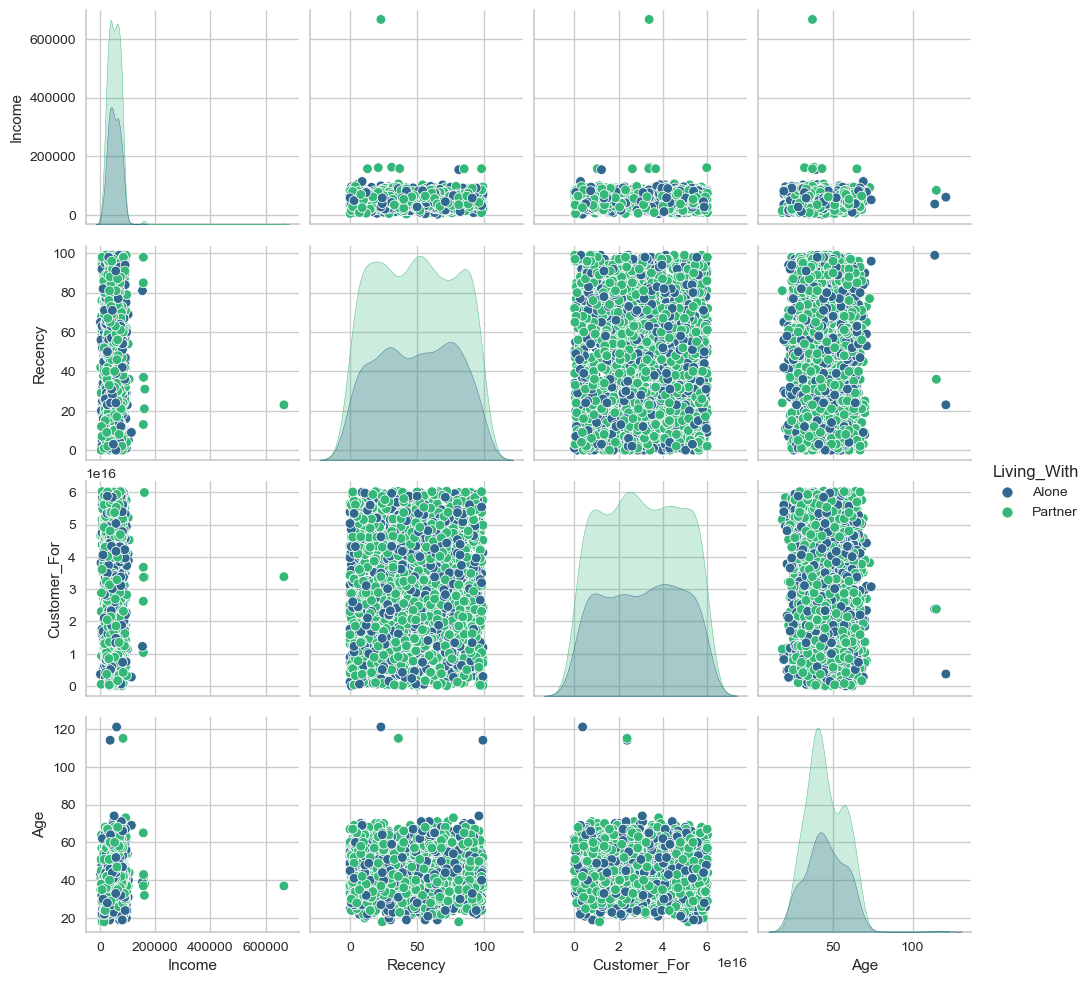

In [25]:
To_Plot = ['Income', 'Recency', 'Customer_For', 'Age', 'Living_With']
plt.figure()
sns.pairplot(data[To_Plot], hue='Living_With', palette='viridis')

Clearly, there are a few outliers int he Income and Age features. So, we will be deleting it later.

C:\Users\ayush\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ayush\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ayush\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ayush\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

<Figure size 800x550 with 0 Axes>

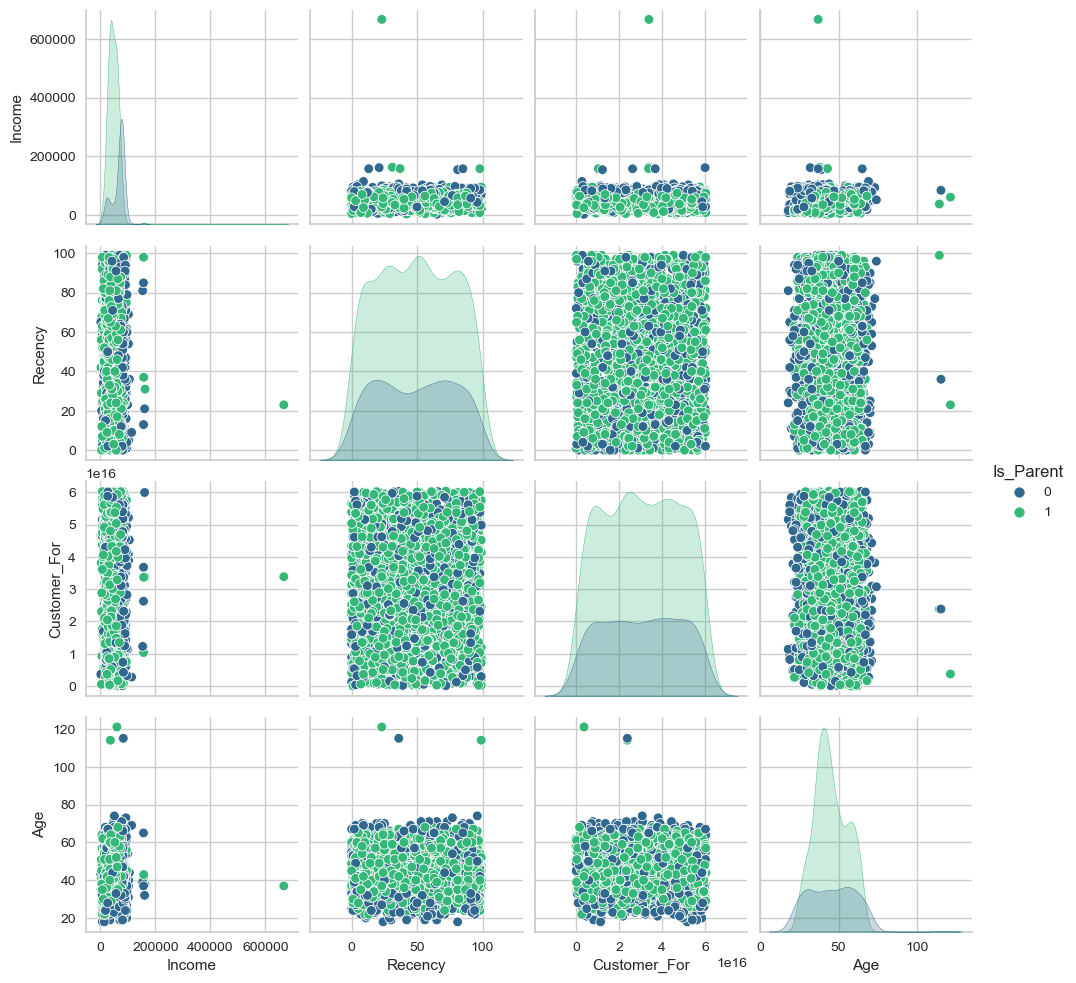

In [26]:
To_Plot = ['Income', 'Recency', 'Customer_For', 'Age', 'Is_Parent']
plt.figure()
sns.pairplot(data[To_Plot], hue='Is_Parent', palette='viridis')

The pair plot indicates that there is no strong linear correlation between most of the pairs of variables. Most of the relationships appear to be weak or non-existent, as indicated by the scattered nature of the points.

In [27]:
data = data[(data['Age']<90)]
data = data[(data['Income']<400000)]
print('Number of data-points after removing the outliers are:', len(data))

Number of data-points after removing the outliers are: 2212


In [28]:
data.dtypes

Education               object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Recency                  int64
Wines                    int64
Fruits                   int64
Meat                     int64
Fish                     int64
Sweets                   int64
Gold                     int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
AcceptedCmp1             int64
AcceptedCmp2             int64
Complain                 int64
Response                 int64
Customer_For             int64
Age                      int64
Spent                    int64
Living_With             object
Children                 int64
Family_Size              int64
Is_Parent                int32
dtype: object

In [29]:
data['Education'] = pd.Categorical(data['Education'])

In [30]:
data['Education'].dtypes

CategoricalDtype(categories=['Graduate', 'PostGraduate', 'Postgraduate', 'UnderGraduate'], ordered=False, categories_dtype=object)

In [31]:
data.columns

Index(['Education', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'Wines',
       'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
       'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response', 'Customer_For',
       'Age', 'Spent', 'Living_With', 'Children', 'Family_Size', 'Is_Parent'],
      dtype='object')

Now, taking a look at the correaltion amongst the features

<Axes: >

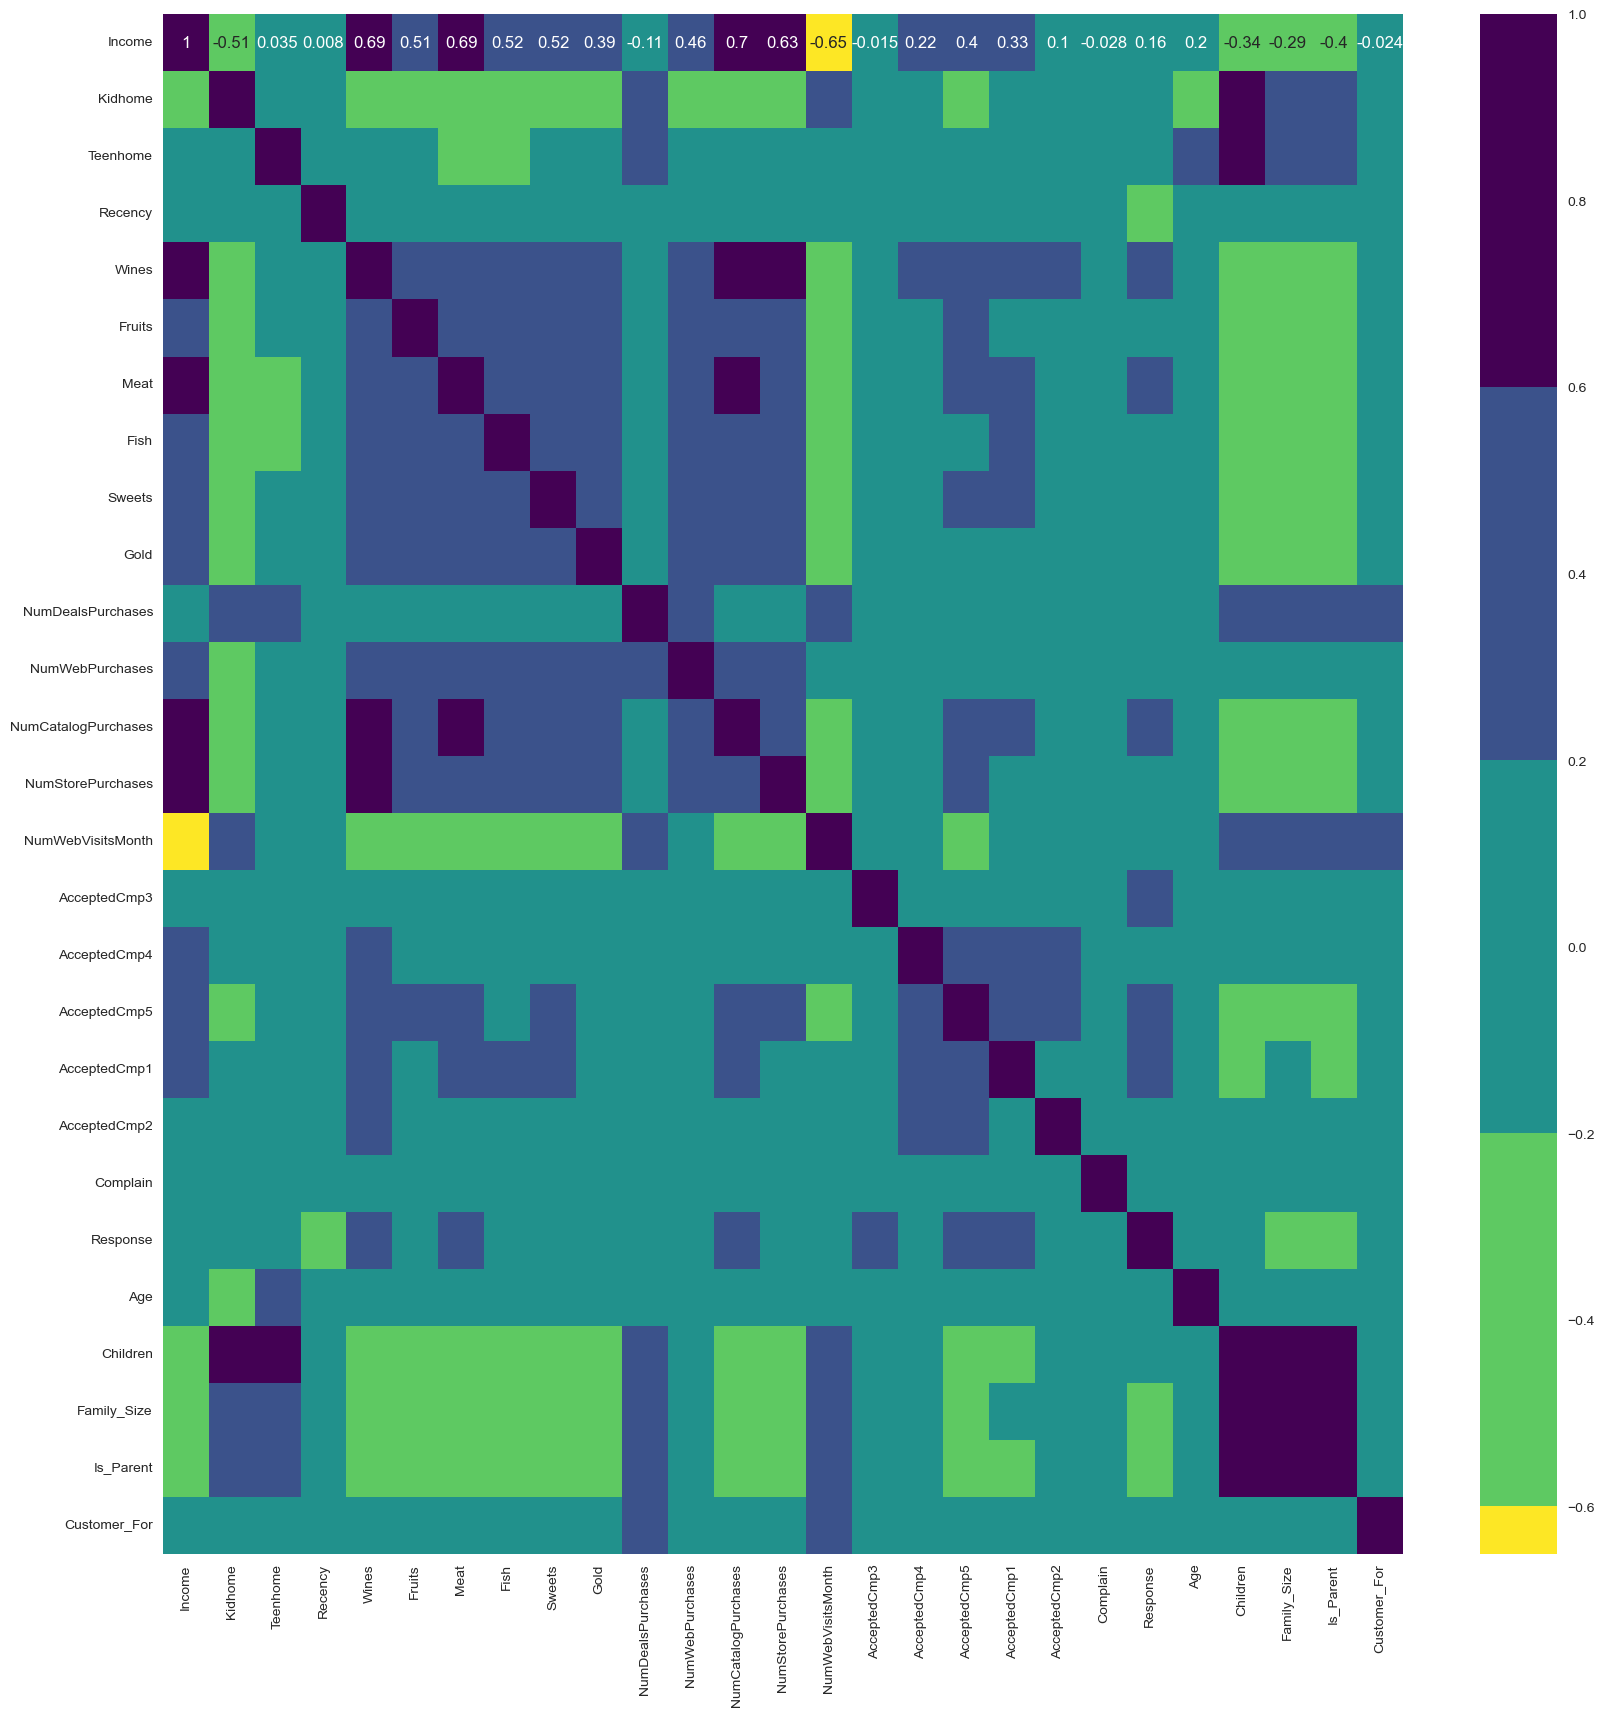

In [32]:
selected_columns = ['Income', 'Kidhome', 'Teenhome', 'Recency', 'Wines',
                    'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold', 'NumDealsPurchases',
                    'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
                    'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
                    'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response', 'Age', 'Children',
                    'Family_Size', 'Is_Parent', 'Customer_For']
corrmat = data[selected_columns].corr()
plt.figure(figsize=(20,20))
sns.heatmap(corrmat, annot=True, cmap=cmap, center=0)


No two columns are too much correlated with each other so we can't drop any column on the basis of correlation.

In [33]:
data.head()

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,AcceptedCmp2,Complain,Response,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,Graduate,58138.0,0,0,58,635,88,546,172,88,...,0,0,1,57283200000000000,57,1617,Alone,0,1,0
1,Graduate,46344.0,1,1,38,11,1,6,2,1,...,0,0,0,9763200000000000,60,27,Alone,2,3,1
2,Graduate,71613.0,0,0,26,426,49,127,111,21,...,0,0,0,26956800000000000,49,776,Partner,0,2,0
3,Graduate,26646.0,1,0,26,11,4,20,10,3,...,0,0,0,12009600000000000,30,53,Partner,1,3,1
4,Postgraduate,58293.0,1,0,94,173,43,118,46,27,...,0,0,0,13910400000000000,33,422,Partner,1,3,1


In [34]:
data['Recency_Cut'] = pd.qcut(data['Recency'], 5)
data['Recency_Cut']

0         (39.0, 58.6]
1         (19.0, 39.0]
2         (19.0, 39.0]
3         (19.0, 39.0]
4         (79.0, 99.0]
             ...      
2235      (39.0, 58.6]
2236      (39.0, 58.6]
2237      (79.0, 99.0]
2238    (-0.001, 19.0]
2239      (39.0, 58.6]
Name: Recency_Cut, Length: 2212, dtype: category
Categories (5, interval[float64, right]): [(-0.001, 19.0] < (19.0, 39.0] < (39.0, 58.6] < (58.6, 79.0] < (79.0, 99.0]]

In [35]:
R_bins = [-0.001,9.0,19.0,39.0,58.6,79.0,99.0]
R_labels = [0,1,2,3,4,5]
data['Recency_C'] = pd.cut(data['Recency'], bins = R_bins, labels=R_labels)

C:\Users\ayush\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ayush\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ayush\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ayush\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed

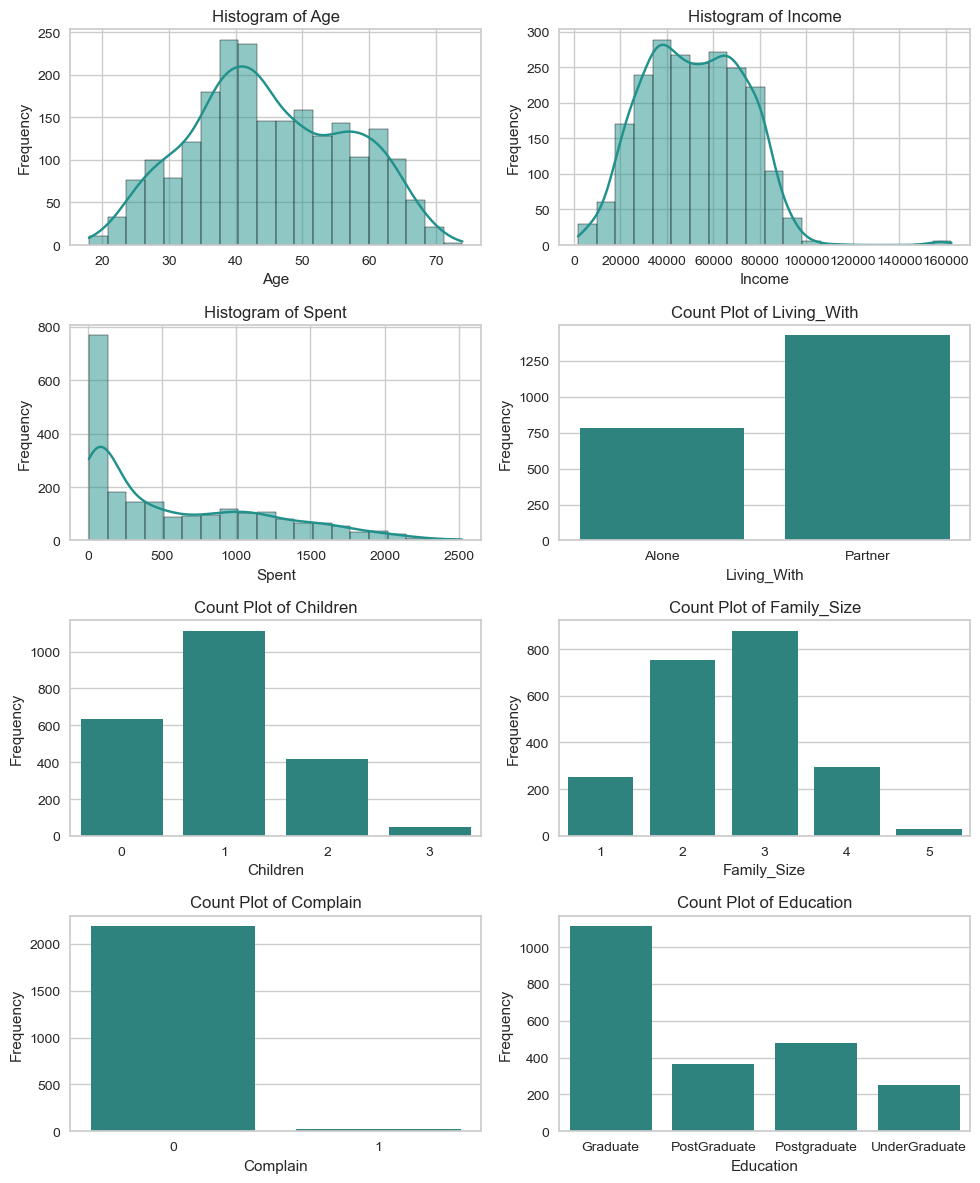

In [36]:
continuous_columns = ['Age', 'Income', 'Spent']
categorical_columns = ['Living_With', 'Children', 'Family_Size', 'Complain', 'Education']
all_columns = continuous_columns + categorical_columns
num_rows = (len(all_columns) + 1) // 2

fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(10, num_rows * 3))
axes = axes.flatten()

for i, col in enumerate(all_columns):
    if col in continuous_columns:
        sns.histplot(data=data, x=col, bins=20, ax=axes[i], kde=True, color='#21918c')
        axes[i].set_title(f'Histogram of {col}')
    elif col in categorical_columns:
        sns.countplot(data=data, x=col, ax=axes[i], color='#21918c')
        axes[i].set_title(f'Count Plot of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

In [37]:
data.head()

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,Response,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent,Recency_Cut,Recency_C
0,Graduate,58138.0,0,0,58,635,88,546,172,88,...,1,57283200000000000,57,1617,Alone,0,1,0,"(39.0, 58.6]",3
1,Graduate,46344.0,1,1,38,11,1,6,2,1,...,0,9763200000000000,60,27,Alone,2,3,1,"(19.0, 39.0]",2
2,Graduate,71613.0,0,0,26,426,49,127,111,21,...,0,26956800000000000,49,776,Partner,0,2,0,"(19.0, 39.0]",2
3,Graduate,26646.0,1,0,26,11,4,20,10,3,...,0,12009600000000000,30,53,Partner,1,3,1,"(19.0, 39.0]",2
4,Postgraduate,58293.0,1,0,94,173,43,118,46,27,...,0,13910400000000000,33,422,Partner,1,3,1,"(79.0, 99.0]",5


In [38]:
data.dtypes

Education              category
Income                  float64
Kidhome                   int64
Teenhome                  int64
Recency                   int64
Wines                     int64
Fruits                    int64
Meat                      int64
Fish                      int64
Sweets                    int64
Gold                      int64
NumDealsPurchases         int64
NumWebPurchases           int64
NumCatalogPurchases       int64
NumStorePurchases         int64
NumWebVisitsMonth         int64
AcceptedCmp3              int64
AcceptedCmp4              int64
AcceptedCmp5              int64
AcceptedCmp1              int64
AcceptedCmp2              int64
Complain                  int64
Response                  int64
Customer_For              int64
Age                       int64
Spent                     int64
Living_With              object
Children                  int64
Family_Size               int64
Is_Parent                 int32
Recency_Cut            category
Recency_

## Data Preprocessing

In this section, I will be preprocessing the data to perform clustering operations.

The following steps are applied to preprocess the data:

Label encoding the categorical features
Scaling the features using the standard scaler
Creating a subset dataframe for dimensionality reduction

In [39]:
cate = []
for col in data.columns:
  if data[col].dtypes in ["object", "category"]:
    cate.append(col)

print(cate)

['Education', 'Living_With', 'Recency_Cut', 'Recency_C']


We will use Label Encoding Instead of one-Hot Encoding as the number of unique categories is large so it will increases the dimensionality of the dataset, which may impact model performance.

In [40]:
LE=LabelEncoder()
for i in cate:
    data[i]=data[[i]].apply(LE.fit_transform)

print("All features are now numerical")

All features are now numerical


In [41]:
ds = data.copy()
# creating a subset of dataframe by dropping the features on deals accepted and promotions
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
ds = ds.drop(cols_del, axis=1)
#Scaling
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )
print("All features are now scaled")

All features are now scaled


In [42]:
print("Dataframe to be used for further modelling:")
scaled_ds.head()

Dataframe to be used for further modelling:


,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,NumWebVisitsMonth,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent,Recency_Cut,Recency_C
0,-0.868542,0.287105,-0.822754,-0.929699,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,...,0.692181,1.527721,1.018352,1.676245,-1.349603,-1.264598,-1.758359,-1.581139,0.008289,0.073450
1,-0.868542,-0.260882,1.040021,0.908097,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,...,-0.132545,-1.189011,1.274785,-0.963297,-1.349603,1.404572,0.449070,0.632456,-0.696932,-0.556284
2,-0.868542,0.913196,-0.822754,-0.929699,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,...,-0.544908,-0.206048,0.334530,0.280110,0.740959,-1.264598,-0.654644,-1.581139,-0.696932,-0.556284
3,-0.868542,-1.176114,1.040021,-0.929699,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,...,0.279818,-1.060584,-1.289547,-0.920135,0.740959,0.069987,0.449070,0.632456,-0.696932,-0.556284
4,0.977892,0.294307,1.040021,-0.929699,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,...,-0.132545,-0.951915,-1.033114,-0.307562,0.740959,0.069987,0.449070,0.632456,1.418731,1.332917


## Dimensionality Reduction

In this problem, there are many factors on the basis of which the final classification will be done. These factors are basically attributes or features. The higher the number of features, the harder it is to work with it. Many of these features are correlated, and hence redundant. This is why I will be performing dimensionality reduction on the selected features before putting them through a classifier.
Dimensionality reduction is the process of reducing the number of random variables under consideration, by obtaining a set of principal variables.

Principal component analysis (PCA) is a technique for reducing the dimensionality of such datasets, increasing interpretability but at the same time minimizing information loss.

Steps in this section:

Dimensionality reduction with PCA
Plotting the reduced dataframe

In [43]:
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,2212.0,-3.212219e-17,2.878415,-5.992150,-2.534800,-0.777441,2.371157,7.461896
col2,2212.0,6.424437e-17,1.739013,-4.716907,-1.258041,0.014405,1.235847,5.428435
col3,2212.0,5.139550e-17,1.691986,-4.394461,-1.238169,0.008267,1.181203,5.565180


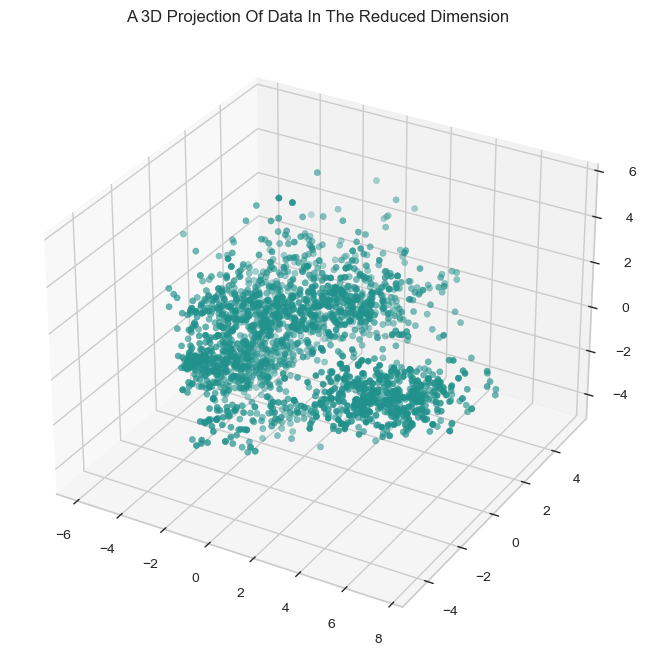

In [44]:
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c='#21918c', marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

## Clustering

Steps involved in the Clustering

Elbow Method to determine the number of clusters to be formed
Clustering via KMeans Clustering
Examining the clusters formed via scatter plot

Elbow Method to determine the number of clusters to be formed:


C:\Users\ayush\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
C:\Users\ayush\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
C:\Users\ayush\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
C:\Users\ayush\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

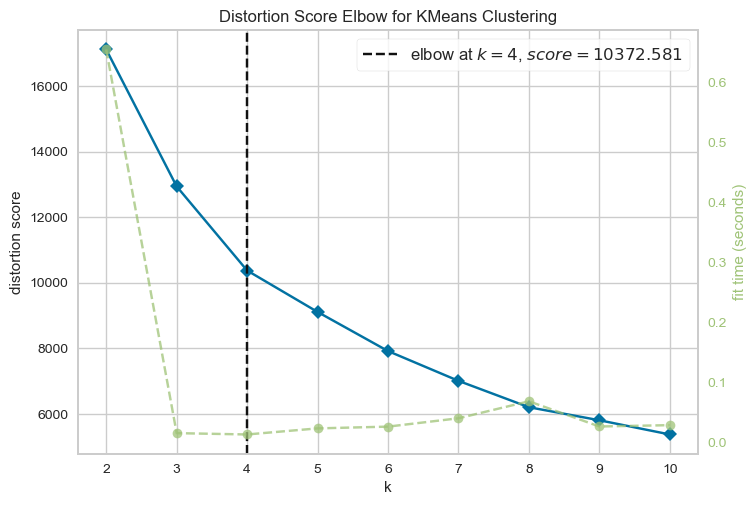

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [45]:
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

The above cell indicates that four will be an optimal number of clusters for this data. Next, we will be fitting the Agglomerative Clustering Model to get the final clusters

In [46]:
AC = AgglomerativeClustering(n_clusters=4)
# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds["Clusters"] = yhat_AC
#Adding the Clusters feature to the orignal dataframe.
data["Clusters"]= yhat_AC

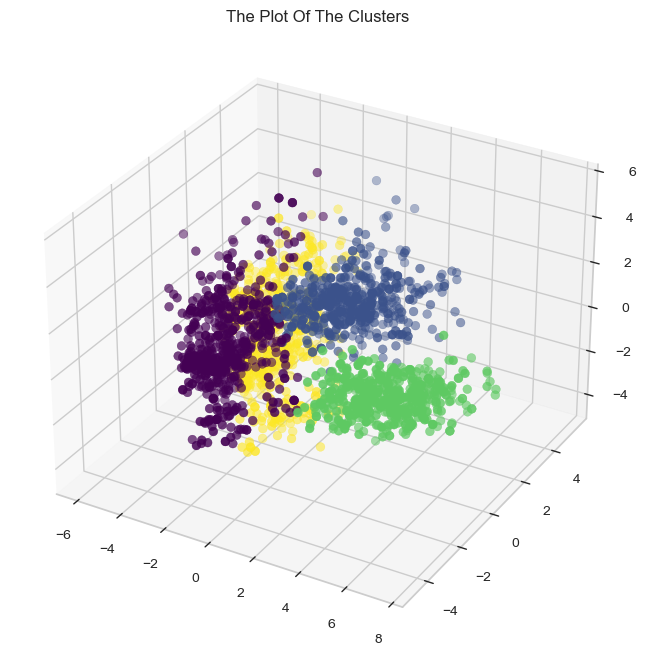

In [47]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters"], marker='o', cmap = cmap )
ax.set_title("The Plot Of The Clusters")
plt.show()

## Evaluating Models

Since this is an unsupervised clustering. We do not have a tagged feature to evaluate or score our model. The purpose of this section is to study the patterns in the clusters formed and determine the nature of the clusters' patterns.

For that, we will be having a look at the data in light of clusters via exploratory data analysis and drawing conclusions.

Firstly, let us have a look at the group distribution of clustring

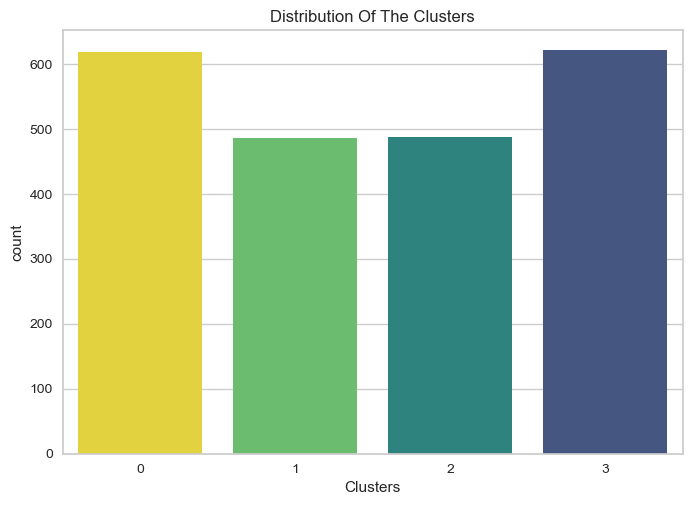

In [48]:
pal=["#fde725", "#5ec962", "#21918c", "#3b528b", "#440154"]
pl = sns.countplot(x=data["Clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

The clusters seem to be fairly distributed.

C:\Users\ayush\AppData\Local\Temp\ipykernel_32368\4056464415.py:1: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  pl = sns.scatterplot(data = data,x=data["Spent"], y=data["Income"],hue=data["Clusters"], palette= pal)


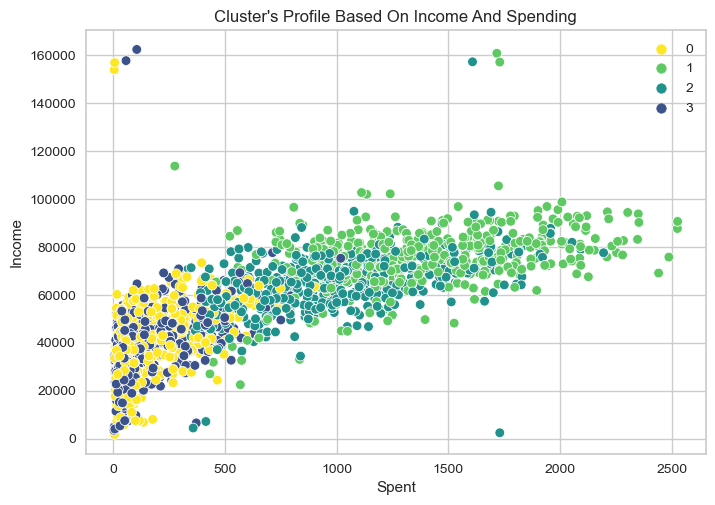

In [49]:
pl = sns.scatterplot(data = data,x=data["Spent"], y=data["Income"],hue=data["Clusters"], palette= pal)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

* group 0: low spending & low income
* group 1: high spending & high income
* group 2: high spending & average income
* group 3: average spending & low income

C:\Users\ayush\AppData\Local\Temp\ipykernel_32368\1873819312.py:1: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  p2 = sns.scatterplot(data = data,x=data["Spent"], y=data["Family_Size"],hue=data["Clusters"], palette= pal)


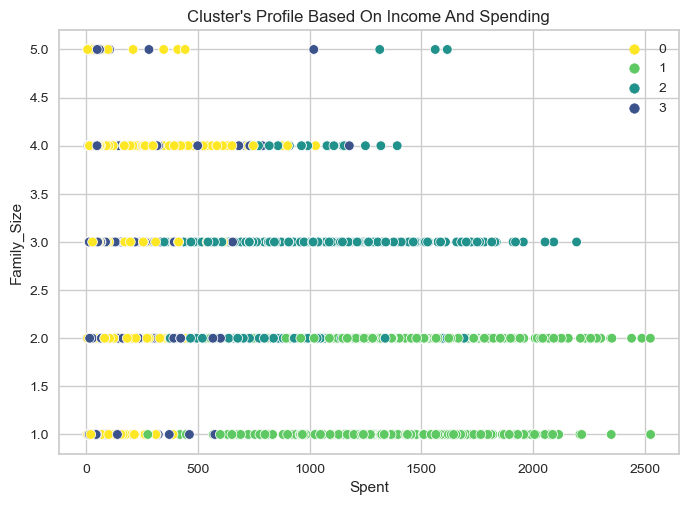

In [50]:
p2 = sns.scatterplot(data = data,x=data["Spent"], y=data["Family_Size"],hue=data["Clusters"], palette= pal)
p2.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

AttributeError: 'numpy.int64' object has no attribute 'startswith'

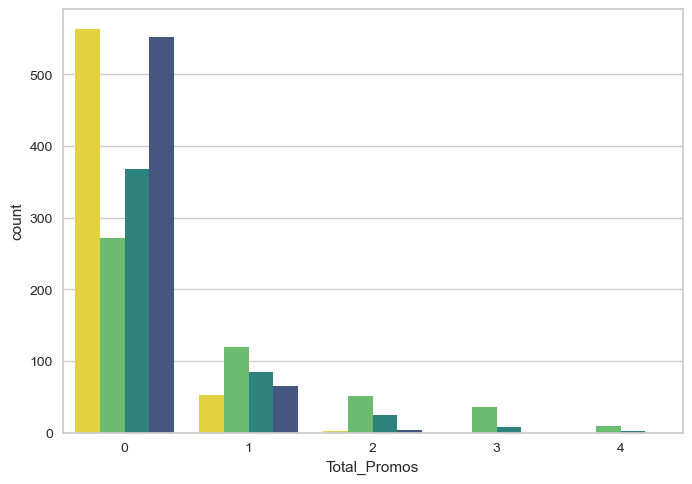

In [51]:
data["Total_Promos"] = data["AcceptedCmp1"]+ data["AcceptedCmp2"]+ data["AcceptedCmp3"]+ data["AcceptedCmp4"]+ data["AcceptedCmp5"]
#Plotting count of total campaign accepted.
plt.figure()
pl = sns.countplot(x=data["Total_Promos"],hue=data["Clusters"], palette= pal)
pl.set_title("Count Of Promotion Accepted")
pl.set_xlabel("Number Of Total Accepted Promotions")
plt.show()

There has not been an overwhelming response to the campaigns so far. Very few participants overall. Moreover, no one part take in all 5 of them. Perhaps better-targeted and well-planned campaigns are required to boost sales.

In [ ]:
data.head()

In [ ]:
dnf.reset_index()

In [ ]:
dnf['Date'] = pd.to_datetime(dnf['Dt_Customer'],format='mixed')
dnf.set_index('Date', inplace=True)
ts_data = dnf['Spent'].resample('M').sum()

train_data = ts_data[:-12]
test_data = ts_data[-12:]

model = ARIMA(train_data, order=(3, 1, 3))
fit = model.fit()
forecast = fit.forecast(steps=12)

forecast_steps = 12
forecast = fit.forecast(steps=forecast_steps)


plt.figure(figsize=(10, 6))
plt.plot(ts_data, label='Observed')
plt.plot(forecast, label='Forecast', color='red')
plt.axvline(x=train_data.index[-1], color='black', linestyle='--', label='Forecast Start')
plt.legend(loc='best')
plt.title('ARIMA Forecast')
plt.show()

print("Forecasted values:")
print(forecast)

extended_forecast_steps = 24
extended_forecast = fit.forecast(steps=extended_forecast_steps)

plt.figure(figsize=(10, 6))
plt.plot(ts_data, label='Observed')
plt.plot(pd.date_range(ts_data.index[-1] + pd.offsets.MonthEnd(1), periods=extended_forecast_steps, freq='M'),
         extended_forecast, label='Extended Forecast', color='red')
plt.axvline(x=ts_data.index[-1], color='black', linestyle='--', label='Forecast Start')
plt.legend(loc='best')
plt.title('Extended ARIMA Forecast')
plt.show()

print("Extended forecasted values:")
print(extended_forecast)

#Conclusion

In conclusion, with the help of "Custometrics: Customer Segmentation and Prediction" we have successfully segmented the customer base and developed prediction models. By leveraging customer data, we were able to identify distinct customer groups with unique characteristics and behaviors. This allows for targeted marketing campaigns, product recommendations, and loyalty programs tailored to each segment. This approach can significantly improve customer engagement, satisfaction, and ultimately, drive business growth.